# Autoregressive Integrated Moving Average (ARIMA)

#### STEP 0: LOAD DATA AND LIBRARIES

In [1]:
import pandas as pd
import warnings
import itertools
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# from google.colab import files
# uploaded = files.upload()

# !ls
# !rm "day.csv"
#  Here we are using a dataset on the number of bicycles checkouts from a bike sharing service for a 3 month period

In [2]:
# load in your data "day.csv"
# preview your data
data=pd.read_csv("day.csv",header=0,parse_dates=['dteday'],index_col=['dteday'],squeeze=True)
#data['Date']=pd.to_datetime(data['dteday'])
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985.0
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801.0
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349.0
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562.0
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600.0


In [3]:
# choose your column : cnt
used_data=data[['cnt']]

#.reset_index()
used_data.head()

,cnt
dteday,
2011-01-01,985.0
2011-01-02,801.0
2011-01-03,1349.0
2011-01-04,1562.0
2011-01-05,1600.0


Let's perform a quick plot to understand/visualise what the data looks like.

#### STEP 1: CHECK FOR DATA STATIONARITY

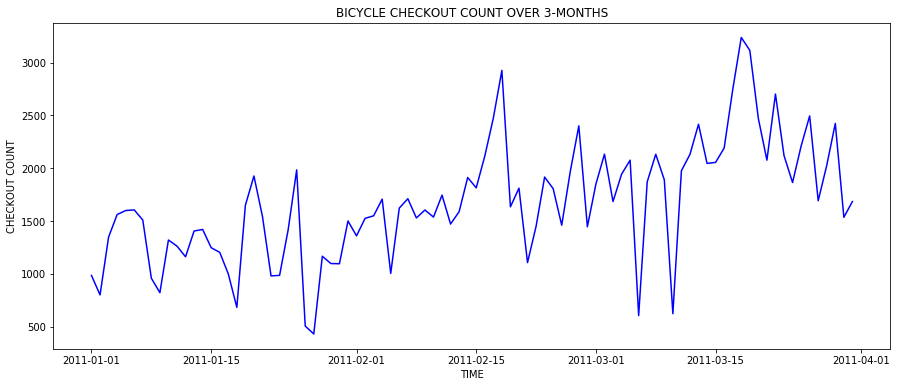

In [4]:
# quick vusalisation
plt.figure(figsize=(15,6))
plt.plot(used_data, color='blue')
plt.xlabel('TIME')
plt.ylabel('CHECKOUT COUNT')
plt.title('BICYCLE CHECKOUT COUNT OVER 3-MONTHS');

**OBSERVATION:** From visual perception the plot shows a trend. Further test for non-stationarity will be performed to confirm non-stationarity of data. Test for constant rolling mean and std are obvious from graph hence would not be done

In [5]:
# Perform agumented Dickey Fuller test
test=adfuller(used_data.cnt,autolag='AIC')
dfuller_test=pd.Series(test[0:2], index=['T-stat','p-value'])
                            
dfuller_test

T-stat    -1.490138
p-value    0.538384
dtype: float64

**OBSERVATION:** A p-value 0.538384>default signifcance level(0.05) shows graph non-stationary hence transformation required

We can see a general increase in the dataset which we can refer to as a trend.  

This suggests that the time series is not stationary and will require differencing to make it stationary.  
This means we are going to try to take out the trend component: d = 1

**STEP 2:APPLY DIFFERENCE TO TRANSFORM DATA**

Apply d=1 and d2 then test for stationarity

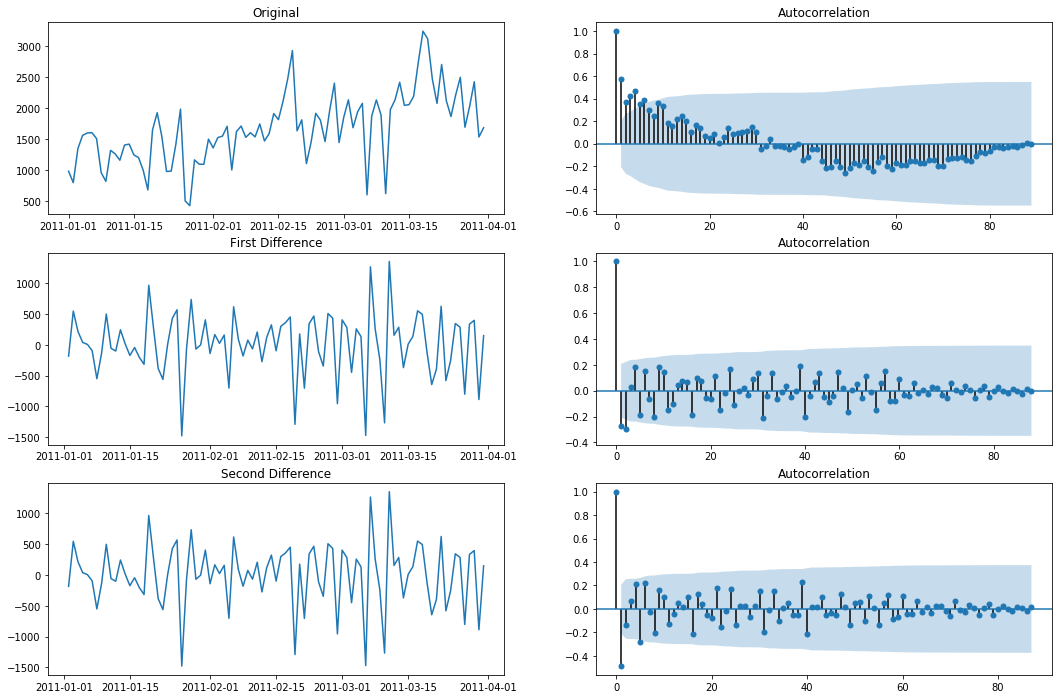

In [6]:
fig,axes=plt.subplots(3,2,figsize=(18,12))
axes[0,0].plot(used_data); axes[0,0].set_title('Original')
plot_acf(used_data,ax=axes[0,1]);

axes[1,0].plot(used_data.diff());axes[1,0].set_title('First Difference')
plot_acf(used_data.diff().dropna(),ax=axes[1,1]);

axes[2,0].plot(used_data.diff());axes[2,0].set_title('Second Difference')
plot_acf(used_data.diff().diff().dropna(),ax=axes[2,1]);

**PS:** From the autocorelation plot after the first difference its observed that the all other paramters are within the limits. Howeve, Augumented Dickey fuller test will be performed to ascertain this

In [7]:
# Perform agumented Dickey Fuller test
test=adfuller(used_data.cnt.diff().dropna(),autolag='AIC')
dfuller_test=pd.Series(test[0:2], index=['T-stat','p-value'])
                            
dfuller_test

T-stat    -5.089926
p-value    0.000015
dtype: float64

In [8]:
# Perform agumented Dickey Fuller test
test=adfuller(used_data.cnt.diff().diff().dropna(),autolag='AIC')
dfuller_test=pd.Series(test[0:2], index=['T-stat','p-value'])
                            
dfuller_test

T-stat    -5.736031e+00
p-value    6.435375e-07
dtype: float64

**OBSERVATION:** Data with a differencing of 1 has reached stationarity. Hence our d=1. Next is to evaluate the values of p and q

## p, d, q (arima parameters)

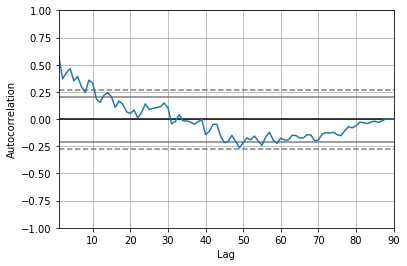

In [9]:
#Plot the autocorrelation plot
autocorrelation_plot(used_data)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


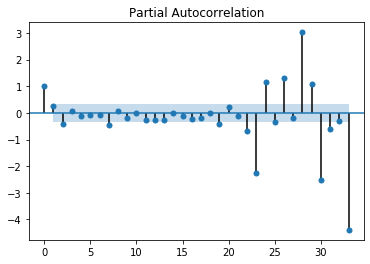

In [10]:
plot_pacf(used_data[1:35])
plt.show()

The autocorrelation plot is saying somewhere around 6 the critical boundary is being reached.  
The value we will experiment with:  p = 6  

The partial-autocorrelation plot shows that there is 1 lags going beyond the critical range.  
The value we will experiment with: q = 1  

Get your pdq values to experiment with and fit the model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.cnt   No. Observations:                   89
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -664.828
Method:                       css-mle   S.D. of innovations            422.047
Date:                Sun, 09 Aug 2020   AIC                           1347.655
Time:                        18:34:38   BIC                           1370.053
Sample:                    01-02-2011   HQIC                          1356.683
                         - 03-31-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.7306     17.668      0.494      0.623     -25.898      43.359
ar.L1.D.cnt    -0.5576      0.392     -1.423      0.159      -1.326       0.211
ar.L2.D.cnt    -0.6194      0.222     -2.788    

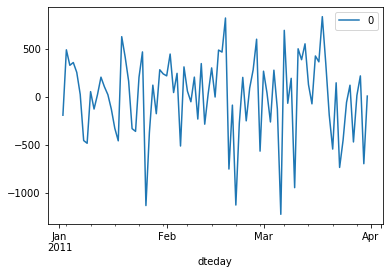

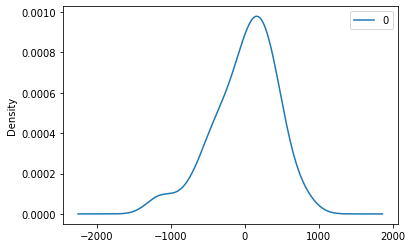

                 0
count    89.000000
mean      4.592785
std     425.864779
min   -1224.485742
25%    -251.394360
50%      52.707904
75%     280.302651
max     833.336368


In [11]:
# fit the model
model = ARIMA(used_data, order=(6,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Rolling Forecast
We now try to use the model to predict future responses.  

predicted=1554.128197, expected=1851.000000
predicted=2032.562039, expected=2134.000000
predicted=1984.734074, expected=1685.000000
predicted=1709.276454, expected=1944.000000
predicted=2071.222075, expected=2077.000000
predicted=1959.571239, expected=605.000000
predicted=1319.860774, expected=1872.000000
predicted=2197.356463, expected=2133.000000
predicted=1776.112382, expected=1891.000000
predicted=1927.358431, expected=623.000000
predicted=1683.173699, expected=1977.000000
predicted=1951.147509, expected=2132.000000
predicted=1820.738584, expected=2417.000000
predicted=1857.692979, expected=2046.000000
predicted=2132.293106, expected=2056.000000
predicted=1842.662803, expected=2192.000000
predicted=2096.996765, expected=2744.000000
predicted=2210.693646, expected=3239.000000
predicted=2767.080081, expected=3117.000000
predicted=2675.774395, expected=2471.000000
predicted=2632.632369, expected=2077.000000
predicted=2576.943392, expected=2703.000000
predicted=2955.437109, expected=21

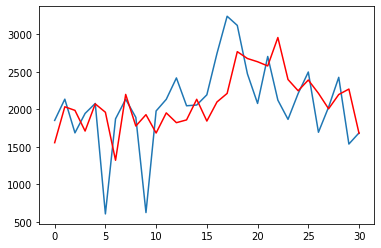

In [12]:
# model prediction
X = used_data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(6,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()